# Problem Set 1
## Learning from data [TIF285], Chalmers, Fall 2019

Last revised: 29-Aug-2019 by Christian Forssén [christian.forssen@chalmers.se]

## Instructions

- See deadline on the course web page
- This problem set is performed individually (but collaboration is encouraged) and contains a number of basic and extra problems; you can choose which and how many to work on.
- See examination rules on the course web page.
- Hand-in is performed through the following **two** actions:
  - Upload of your solution in the form of a jupyter notebook, or python code, via Canvas.
  - Answer the correesponding questions on OpenTA.
  
  Note that the hand-in is not complete, and will not be graded, if any of those actions is not performed.

Fill your personal details
- Name: **Brogren, Frida**
- Personnummer: **940421-1824**
  <br/>
  (civic registration number)

## Problem 1
### (2 basic points)

#### Installations
Perform the installations and preparations that are described in the Getting Started instructions. At the end you should have:

1. downloaded the current version of the course material from the github repository or from the course web page;
2. a running python installation that includes the modules listed in the environment.yml file (e.g. numpy, matplotlib, pandas, emcee, scikit-learn, ...);
3. been able to open and run the Jupyter Notebooks with the first week excercises.
Ask the computer lab supervisors for assistance if needed.

In [1]:
# Import the python modules that are needed for this problem set here
# 
import numpy as np
import matplotlib.pyplot as plt

## Problem 2
### (3 basic points)

#### Generate data

In [111]:
# Generate noisy data with a quadratic feature
# use the following code:
np.random.seed(42)

# X are picked uniform random [0,2]
X = 2 * np.random.rand(100, 1)
# Linear relation to the predicted value, but with Gaussian noise (mean=0, variance=1)
y = 0.5 * X**2 + X + 2 + 0.2 * np.random.randn(100, 1)

#### (a) Perform a linear regression using the Normal Equation
Create the design matrix for a quadratic polynomial and solve the normal equation using matrix inversion.

In [112]:
X_design = np.concatenate((np.ones([100,1]),X,X**2),axis=1)
# theta = (X.T*X)^(-1)*X.T*y

A = np.dot(X_design.T,X_design)
u,s,vh = np.linalg.svd(A)

# A = u*diag(s)*vh --> A⁻¹=vh*(diag(s))⁻¹*u.T  (u and vh are orthogonal)

A_inv = vh.T.dot(np.linalg.inv(np.diag(s))).dot(u.T)

theta = A_inv.dot(X_design.T).dot(y)

print('theta:\n ',theta)


theta:
  [[2.11228054]
 [0.72777588]
 [0.61621274]]


#### (b) Comparisons: 
Compare the coefficients from the true data generator and the normal equation. Plot the data and the model predictions in the same figure.

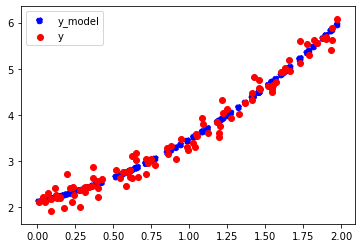

In [113]:
y_model = X_design.dot(theta)

fig = plt.figure()

# call the first axis ax1
ax = fig.add_subplot(1,1,1)  # one row, two columns, first plot
ax.scatter(X,y_model, color='blue', linestyle='--', label='y_model')
ax.scatter(X,y, color='red', linestyle='-', label='y')
ax.legend()



## Problem 3
### (3 basic points)

There are three files in the directory `DataFiles`:
- `dataset1.dat`
- `dataset2.dat`
- `dataset3.dat`

Each data files contains two columns. The first column corresponds to the independent variables (the array X), and the second column corresponds to the dependent ones (the array y).

#### (a) Perform linear regression with different models
- Load a data set and split it into 60% training and 40% validation data using the python commands below.
- For each data set you should then perform linear regression using polynomial models of order 1,2,3,4,5, and 20.
- Print the fit coefficients for each model and print also the mean-squared error (MSE) for both the training and the validation sets.

Questions to ponder:
- Which order polynomial do you think was used when generating the data?
- Which data set do you think has the most noise?

In [40]:
datafile = 'DataFiles/dataset2.dat'
X, y = np.loadtxt(datafile, unpack=True)
m = len(X)
X = X.reshape(m,1); y = y.reshape(m,1)

# built-in convenience function for splitting data
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.6, random_state=42)


validation MSE:  0.13501288555560875
training MSE:  0.24234932883432508
[0.98685097] [[ 1.95040555  0.52366981 -0.24741449]]


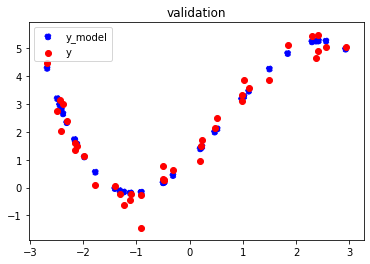

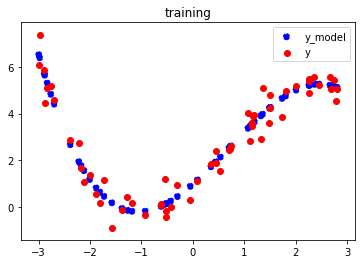

In [45]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def apply_model_function(bias,features,poly_features,X):
    X_poly = poly_features.fit_transform(X)
    y_predict = X_poly.dot(features.T)
    y_predict = y_predict + bias
    return y_predict

def plot_fit(X,y,y_model,title_):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)  
    ax.title.set_text(title_)
    ax.scatter(X,y_model, color='blue', linestyle='--', label='y_model')
    ax.scatter(X,y, color='red', linestyle='-', label='y')
    ax.legend()

def mean_square_error(y,y_predict):
    MSE = np.mean((y-y_predict)**2)
    return MSE



poly_features = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly_features.fit_transform(X_train)

lin_reg = LinearRegression()
lin_reg.fit(X_poly, y_train)

# validation set
y_predict = apply_model_function(lin_reg.intercept_, lin_reg.coef_, poly_features, X_val)
plot_fit(X_val, y_val, y_predict,'validation')
print('validation MSE: ', mean_square_error(y_val, y_predict))

# training set
y_predict = apply_model_function(lin_reg.intercept_, lin_reg.coef_, poly_features, X_train)
plot_fit(X_train, y_train, y_predict,'training')
print('training MSE: ', mean_square_error(y_train, y_predict))

print(lin_reg.intercept_, lin_reg.coef_)




## Problem 4
### (2 basic points)

### Standard medical example by applying Bayesian rules of probability

Suppose there is an unknown disease (call it UD) and there is a test for it.

a. The false positive rate is 2.3%. ("False positive" means the test says you have UD, but you don't.) <br>
b. The false negative rate is 1.4%. ("False negative" means you have UD, but the test says you don't.)

Assume that 1 in 10,000 people have the disease. You are given the test and get a positive result.  Your ultimate goal is to find the probability that you actually have the disease. 
$% Some LaTeX definitions we'll use.
\newcommand{\pr}{\textrm{p}}
$

We'll do it using the Bayesian rules.

We'll use the notation:

* $H$ = "you have UD"
* $\overline H$ = "you do not have UD"  
* $D$ = "you test positive for UD"
* $\overline D$ = "you test negative for UD"  

1. *Before doing a calculation (or thinking too hard :), does your intuition tell you the probability you have the disease is high or low?*
<br>
<br>

2. *In the $p(\cdot | \cdot)$ notation, what is your ultimate goal?*
<br>
Notation: $H$ = "you have UD", &nbsp;&nbsp; $\overline H$ = "you do not have UD",  &nbsp;&nbsp; $D$ = "you test positive for UD", &nbsp;&nbsp;  $\overline D$ = "you test negative for UD"  

3. *Express the false positive rate in $p(\cdot | \cdot)$ notation.* \[Ask yourself first: what is to the left of the bar?\]
<br>
Notation: $H$ = "you have UD", &nbsp;&nbsp; $\overline H$ = "you do not have UD",  &nbsp;&nbsp; $D$ = "you test positive for UD", &nbsp;&nbsp;  $\overline D$ = "you test negative for UD"  


4. *Express the false negative rate in $p(\cdot | \cdot)$ notation. By applying the sum rule, what do you also know? (If you get stuck answering the question, do the next part first.)* 
<br>
Notation: $H$ = "you have UD", &nbsp;&nbsp; $\overline H$ = "you do not have UD",  &nbsp;&nbsp; $D$ = "you test positive for UD", &nbsp;&nbsp;  $\overline D$ = "you test negative for UD"  


5. *Should $p(D|H) + p(D|\overline H) = 1$?
    Should $p(D|H) + p(\overline D |H) = 1$?
    (Hint: does the sum rule apply on the left or right of the $|$?)*
<br>
Notation: $H$ = "you have UD", &nbsp;&nbsp; $\overline H$ = "you do not have UD",  &nbsp;&nbsp; $D$ = "you test positive for UD", &nbsp;&nbsp;  $\overline D$ = "you test negative for UD"  

6. *Apply Bayes' theorem to your result for your ultimate goal (don't put in numbers yet).
   Why is this a useful thing to do here?*
<br>
Notation: $H$ = "you have UD", &nbsp;&nbsp; $\overline H$ = "you do not have UD",  &nbsp;&nbsp; $D$ = "you test positive for UD", &nbsp;&nbsp;  $\overline D$ = "you test negative for UD"  


7. Let's find the other results we need.  *What is $p(H)$?
  What is $p(\overline H)$?*
<br>
Notation: $H$ = "you have UD", &nbsp;&nbsp; $\overline H$ = "you do not have UD",  &nbsp;&nbsp; $D$ = "you test positive for UD", &nbsp;&nbsp;  $\overline D$ = "you test negative for UD"  


8. Finally, we need $p(D)$.  *Apply marginalization first, and then
  the product rule twice to get an expression for $p(D)$ in terms of quantities
  we know.*
<br>
Notation: $H$ = "you have UD", &nbsp;&nbsp; $\overline H$ = "you do not have UD",  &nbsp;&nbsp; $D$ = "you test positive for UD", &nbsp;&nbsp;  $\overline D$ = "you test negative for UD"  

9. *Now plug in numbers into Bayes' theorem and calculate the result.  What do you get?*
<br>
Notation: $H$ = "you have UD", &nbsp;&nbsp; $\overline H$ = "you do not have UD",  &nbsp;&nbsp; $D$ = "you test positive for UD", &nbsp;&nbsp;  $\overline D$ = "you test negative for UD"  


## Problem 5 (extra)
### (3 extra points)

#### Reload the third dataset from Problem 3

In [210]:
datafile = 'DataFiles/dataset3.dat'
X, y = np.loadtxt(datafile, unpack=True)
m = len(X)
X = X.reshape(m,1); y = y.reshape(m,1)

#### Validation curves
Create a validation curve for the polynomial model (for different degrees) where you plot the training score and the validation score as a function of the model complexity. 
- The model complexity is simply the degree of the polynomial.
- For the computation of training and validation scores you are encouraged to use cross-validation which is more stable than the use of a single, random pair of training and validation sets.

Question to ponder:
- From this curve: Which order polynomial do you think was used when generating the data?

*Hint:* `scikit-learn` has a function `validation_curve` that might be useful. However, it is certainly instructive to implement the calculation of learning curves yourself.

## Problem 6 (extra)
### (3 extra points)

### Gradient descent methods

#### Regenerate the data from problem 2

In [132]:
# Generate noisy data with a quadratic feature
# use the following code:
np.random.seed(42)

# X are picked uniform random [0,2]
X = 2 * np.random.rand(100, 1)
# Linear relation to the predicted value, but with Gaussian noise (mean=0, variance=1)
y = 0.5 * X**2 + X + 2 + 0.2 * np.random.randn(100, 1)

#### (a) Batch and stochastic gradient descent
Implement both batch and stochastic gradient descent and use these methods to find the best fit parameters of a quadratic model.
- You might want to tune the learning hyperparameter $\eta$.
- Do 50 epochs for the SGD (each epoch corresponding to using all instances of data once)
- Compare with the solution from Problem 2.

#### (b) Mini-batch gradient descent
Implement mini-batch gradient descent and use this method to find the best fit parameters. Details:
- use a mini-batch size of 20%
- apply a similar learning schedule as in the SGD example (you might have to tune the learning hyperprameters)
- perform 50 epochs 
- hint: the `numpy.random.permutation` function might be useful for creating the mini-batches. 
- Compare with the solutions from BGD and SGD.

#### (c) Convergence
Compare the convergence pattern for the BGD, SGD and MGD, i.e. plot the path towards the optimal set of parameters. 
- Note that the path is in 3D (since there are three parameters in our quadratic model). You can plot 2D projections of the path.